# Validating and Tuning

As is shown in Chapters 5 to 9, ML models require *user-specified* choices before they can be trained - which encompass *parameter values* (learning rate, penalization intensity, etc.) or *architectural choices* (e.g. the structure of a network).

We refer to the work of Probst et al. (2018) for a study on the impact of hyperparameter tuning on model performance.

For some models, the number of degrees of freedom is so large that finding the right parameters can become complicated and challenging.

This chapter addresses these issues but the reader must be aware that there is no shortcut to building good models. Crafting an effective model is time-consuming and often the result of many iterations.

## Learning Metrics

The parameter values that are set before training are called **hyperparameters**. However, the evaluation (of the model performance) requires *metrics*. 

- Two main tasks: regressions (numbers) and classicifications (categories).
- Li et al. (2020) propose to assess the performance of a forecasting method compared to a given benchmark, **conditional** on some external variable.

### Regression Analysis

Errors in regression analyses are usually evaluated with the $L^1$ and $L^2$ norms - both easy to interpret and to compute. 
- The first one is the mean absoluate error, which gives the average distance to the realized value (but is not differetiable at zero).
- The second one is the **root mean squared error (RMSE)** and is differentiable everywhere but harder to grasp and gives more weight to outliers. Formally,

\begin{align*}
\text{MAE}(\textbf{y},\tilde{\textbf{y}})&=\frac{1}{I}\sum_{i=1}^I|y_i-\tilde{y}_i|, \\
\text{MSE}(\textbf{y},\tilde{\textbf{y}})&=\frac{1}{I}\sum_{i=1}^I(y_i-\tilde{y}_i)^2
\end{align*}
and the RMSE is simply the square root of the MSE. 

It's always possible to generalize these formulae by adding weights $w_i$ to produce heterogeneity in the importance of instances.

Let us briefly comment on the MSE, which is by far the most common lost function, but is *not* necessarily the exact best choice for return prediction. If we decompose the loss into 3 terms, we get
1. The sum of squared realized returns
2. The sum of squared predicted returns
3. The product between the two (a roughly covariance term assuming zero means)

The third term is the most interesting from the allocator's standpoint: the negativity of the cross-product $-2y_i \tilde{y}_i$ is always *to the investor's benefit*: both positive for a profitable asset or both negative for a bad opportunity. It is when $y_i$ and $\tilde{y}_i$ don't have the same sign that problems arise. Thus, compared to the $\tilde{y}_i^2$, the cross-term is *more important*. Nonetheless, algorithms *do not optimize* with respect to this indicator.

These metrics (MSE and RMSE) are widely used outside ML to assess forecasting errors. Below, we present other indicators that are also sometimes used to quantify the quality of a model. In line with the linear regressions, the $R^2$ can be computed in any predictive exercise:
$$R^2(\textbf{y},\tilde{\textbf{y}})=1- \frac{\sum_{i=1}^I(y_i-\tilde{y}_i)^2}{\sum_{i=1}^I(y_i-\bar{y})^2}$$
where $\bar{y}$ is the sample average. 

One important difference with the classical $R^2$ is that the above quantity can be computed on the **testing sample** and not on the **training sample**. In this case, the $R^2$ *can be negative* when the MSE in the numerator is larger than the (biased) variance of the testing sample. 

Sometimes, the average value $\bar{y}$ is omitted in the denominator (as in Gu et al. (2020b) for instance). The benefit is that it compares the predictions of the model to a zero prediction. This is particularly relevant with returns *because the simplest prediction of all is the constant zero value* and the $R^2$ can then *measure if the model beats this naive benchmark*. *A zero prediction is always preferable* to a sample average because the latter can be very much period dependent. Also,  removing $\bar{y}$ in the denominator makes the metric more *conservative* as it mechanically reduces the $R^2$.

Other exotic extensions:
1. Mean Absolute Percentage Error (MAPE)
2. Mean Square Percentage Error (MSPE)

They compute the error relative to the original value and is expressed in a percentage score:
\begin{align*}
\text{MAPE}(\textbf{y},\tilde{\textbf{y}})&=\frac{1}{I}\sum_{i=1}^I\left|\frac{y_i-\tilde{y}_i}{y_i}\right|\\
\text{MSPE}(\textbf{y},\tilde{\textbf{y}})&=\frac{1}{I}\sum_{i=1}^I\left(\frac{y_i-\tilde{y}_i}{y_i}\right)^2
\end{align*}
while the latter can be scaled by a square root if needed.

When the label is positive with possibly large values, it is possible to *scale the magnitude of errors*, which can be very large. One way to do this is the Root Mean Squared Logarithmic Error (RMSLE):
$$\text{RMSLE}(\textbf{y},\tilde{\textbf{y}})=\sqrt{\frac{1}{I}\sum_{i=1}^I\log\left(\frac{1+y_i}{1+\tilde{y}_i}\right)}$$
where it is obvious that when $y_i=\tilde{y}_i$, the error metric is 0.

Before we move on to categorical losses, we briefly comment on one shortcoming of the MSE. A simple decomposition yields:
$$\text{MSE}(\textbf{y},\tilde{\textbf{y}})=\frac{1}{I}\sum_{i=1}^I(y_i^2+\tilde{y}_i^2-2y_i\tilde{y}_i)$$
The model can do nothing for $y_i^2$, hence will focus on the minimization of the other two. The second term is the dispersion of model values. The third term is a cross-product, which is by far the most important. This product is indeed positive when the two terms have the same sign, which is exactly what an investor is looking for: **correct directions** for the bets. For some algorith,s, it's possible to manually specify custom losses (see Section 7.4.3, maximizing the sum of $y_i\tilde{y}_i$ may be a good alternative to vanilla quadratic optimization.)

### Classification Analysis

We present the concepts pertaining to these metrics in an increasing order of complexity. In binary classification, it is convenient to think in terms of *true versus false*. In an investment setting, true can be related to a positive return, or a return being above that of a benchmark - false being the opposite.

There are 4 types of possible results for a prediction:
- Frequency of *true positive*: $TP=I^{-1}\sum_{i=1}^I 1_{y_i=\tilde{y}_i=1},$
- Frequency of *true negative*: $TN=I^{-1}\sum_{i=1}^I 1_{y_i=\tilde{y}_i=0},$
- Frequency of *false positive*: $FP=I^{-1}\sum_{i=1}^I 1_{y_i=0,\tilde{y}_i=1},$
- Frequency of *false negative*: $FN=I^{-1}\sum_{i=1}^I 1_{y_i=1,\tilde{y}_i=0},$

where true is conventionally encoded into 1 and false into 0. The sum of the four figures is 1. These four numbers have very different impacts on out-of-sample results, as shown in the following figure. In this table (also called a **confusion matrix**), it is assumed that some proxy for future profitability is forecast by the model. Each row stands for the model's prediction and each column for the realization of the profitability. 

![FIGURE 10.1: Confusion matrix: summary of binary outcomes.](images/figure10-1.png)

Among the two types of errors, **type I** is the most daunting for investors because it has a direct effect on the portfolio. The **type II** error is a simply missed opportunity and is somewhat less impactful. Finally, true negatives are those assets which are correctly excluded from the portfolio.

From the 4 baseline rates, it's possible to derive other interesting metrics:
- **Accuracy** $=TP+TN$ is the percentage of correct forecasts
- **Recall** $=\frac{TP}{TP+FN}$ measures the ability to detect a winning strategy/asset (left column), also known as *sensitivity* or *true positive rate (TPR)*;
- **Precision** $=\frac{TP}{TP+FP}$ computes the probability of good investments (top row);
- **Specificity** $=\frac{TN}{TN+FP}$ measures the proportion of actual negatives that are correctly identified (right column);
- **Fallout** $=\frac{FP}{TN+FP}=1-\text{Specificity}$ is the probability of false alarm (or false positive rate), i.e., the frequency at which the algorithm detects falsely performing assets (right column);
- **F-score**, $F_1=2\times \frac{\text{recall} \times \text{precision}}{\text{recall} + \text{precision}}$ is the harmonic average of recall and precision.

All these metrics lie in the unit interval and is deemed to perform better when they increase (except fallout). Other indicators also exist, like the false discovery rate or false omission rate but less mainstream.

A metric that is popular but more complex is the Area Under the (ROC) Curve, often referred to as *AUC*. The complicated part is the *ROC curve* where ROC stands for Receiver Operating Characteristic (comes from signal theory).

As seen in Chapters 6 and 7, classifiers generate output that are probabilities that one instance belongs to one class. These probabilities are then translated into a class by choosing the class that has the highest value. In binary classification, the class with a score *above 0.5* basically wins.

In practice, this 0.5 threshold *may not be optimal* and the model could very well correctly predict false instances when the probability is below 0.4 and true ones otherwise. Hence, it is a natural idea to test what happens if the decision threshold changes. The ROC curve does just that and plots the recall as a function of the fallout when the threshold increases from zero to one.

- When the threshold is 0: TP is always 0 because the model never forecasts positive values - both recall and fallout are 0.
- When the threshold is 1: FP shrinks to 0 and TN too, hence recall and fallout are 1.
- The behaviour of their relationship between two extremes is the **ROC curve**. See the following figure 10.2 for a stylized example.

![FIGURE 10.2: Stylized ROC curves.](images/figure10-2.png)

An algorithm with a ROC curve above the 45° angle is performing better than an average classifier. Indeed, the curve can be seen as a tradeoff between benefits (probability of detecting good strategies on the $y$ axis) minus costs (odds of selecting the wrong assets on the $x$ axis).

The best possible classifier has a ROC curve that goes from point $(0,0)$ to point $(0,1)$ to point $(1,1)$. At point $(0,1)$, fallout is null, hence there are no false positives, and recall is 1 so that there are no false negatives: the model is always right. The opposite is true: at point $(1,0)$, the model is always wrong.

Below, we will use the `sklearn` package to comupute a ROC curve for a given set of predictions on the testing sample.

In [1]:
import numpy as np
import pandas as pd

data_ml = pd.read_pickle('./data/data_ml.pkl')
X = data_ml[data_ml.columns[2:95]]
y = data_ml['R1M_Usd']

separation_date = pd.to_datetime('2014-01-15')
training_sample = data_ml[data_ml['date'] < separation_date]
test_sample = data_ml[data_ml['date'] > separation_date]

In [2]:
from sklearn.ensemble import RandomForestClassifier
fit_rf_c = RandomForestClassifier(n_estimators = 40,
                                  min_samples_split = 250,
                                  max_features = 30,
                                  max_samples = 20000)

fit_rf_c.fit(training_sample[training_sample.columns[2:95]], training_sample['R1M_Usd_C'])

RandomForestClassifier(max_features=30, max_samples=20000,
                       min_samples_split=250, n_estimators=40)

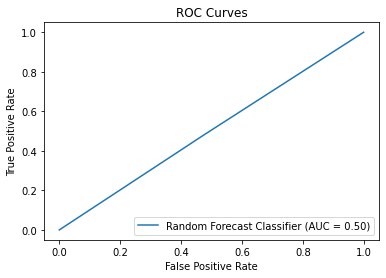

In [4]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(test_sample['R1M_Usd_C'].values,
                                 fit_rf_c.predict(test_sample[test_sample.columns[2:95]]))
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                          estimator_name='Random Forecast Classifier')
display.plot()
plt.title("ROC Curves")
plt.show()

In [6]:
roc_auc

0.5027044855719038

In the previous figure, the curve is very close to the 45° angle and the model seems rather as bad as a random classifier.

For comparison purpose, having one entire curve is not practical, hence the information of the whole curve is synthesized into the area below the curve, i.e., the integral of the corresponding function. The 45° angle (quadrant bisector) has an area of 0.5. Thus, any good model is expected to have an AUC above 0.5. A perfect model has an AUC of 1.

We end this subsection with a word on *multiclass* data. Things are more complex in this case. It is still possible to compute a confusion matrix, but the dimension is larger and harder to interpret, and TP, TN, etc. must be generalized in a non-standard way. The simplest metric is the *cross-entropy* defined in Chapter 7. We refer to Section 6.1.2 for more details on losses related to categorical labels.

## Validation
Validation is the stage at which a model is tested and tuned before it starts to be deployed on real or live data (for trading purposes).

### The variance-bias tradeoff: theory

The **variance-bias tradeoff** is one of the core concepts in supervised learning. To explain it, let us assume that the data is generated by the simple model $$y_i=f(\textbf{x}_i)+\epsilon_i, \quad   \mathbb{E}[\boldsymbol{\epsilon}]=0, \quad \mathbb{V}[\boldsymbol{\epsilon}]=\sigma^2$$
but the model that is estimated yields $$y_i=\hat{f}(\boldsymbol{x}_i)+\hat{\epsilon}_i$$
Given an unknown sample $\boldsymbol{x}$, the decomposition of the average squared error is 
\begin{align*}
\mathbb{E}[\hat{\epsilon}^2]&=\mathbb{E}[(y-\hat{f}(\textbf{x}))^2]=\mathbb{E}[(f(\textbf{x})+\epsilon-\hat{f}(\textbf{x}))^2]   \\
&= \underbrace{\mathbb{E}[(f(\textbf{x})-\hat{f}(\textbf{x}))^2]}_{\text{total quadratic error}}+\underbrace{\mathbb{E}[\epsilon^2]}_{\text{irreducible error}}\\
&= \mathbb{E}[\hat{f}(\textbf{x})^2]+\mathbb{E}[f(\textbf{x})^2]-2\mathbb{E}[f(\textbf{x})\hat{f}(\textbf{x})]+\sigma^2\\
&=\mathbb{E}[\hat{f}(\textbf{x})^2]+f(\textbf{x})^2-2f(\textbf{x})\mathbb{E}[\hat{f}(\textbf{x})]+\sigma^2\\
&=\left[ \mathbb{E}[\hat{f}(\textbf{x})^2]-\mathbb{E}[\hat{f}(\textbf{x})]^2\right]+\left[\mathbb{E}[\hat{f}(\textbf{x})]^2+f(\textbf{x})^2-2f(\textbf{x})\mathbb{E}[\hat{f}(\textbf{x})]\right]+\sigma^2\\
&=\underbrace{\mathbb{V}[\hat{f}(\textbf{x})]}_{\text{variance of model}}+ \quad \underbrace{\mathbb{E}[(f(\textbf{x})-\hat{f}(\textbf{x}))]^2}_{\text{squared bias}}\quad +\quad\sigma^2
\end{align*}

In the above derivation, $f(x)$ is not random but $\hat{f}(x)$ is. Also, in the second line, we assumed that $\mathbb{E}[\varepsilon(f(x)-\hat{f}(x))]=0$, which may not always hold (though it's a very common assumption).

The average squared error has 3 components:
- The variance of the model (over its predictions);
- The squared bias of the model;
- And one **irreducible error** (independent from the choice of a particular model).

The last one is immune to change in models, so the challenge is to minimize the *sum of the first two*. This is known as the **variance-bias tradeoff** because reducing one often leads to increasing the other. The goal is thus to access when a small increase in either one can lead to a larger decrease in the other.

Below in the following figure we present two of them. The first one relates to archery (see the following figure) below. The top left and the bottom right cases are the best and worst cases possible. However, the most often encountered cases in ML are the other two configurations:
- The arrows are concentrated in a small parameter but not the center of the target;
- The arrows are on average well distributed but on average far from the center.

![FIGURE 10.4: First representation of the variance-bias tradeoff.](images/figure10-4.png)

The second way this tradeoff is often depicted is via the notion of **model complexity**.
- The most simple model: a constant one (or the average value of the label in the training set) - zero variance but large bias.
- On the other side, a decision tree with as many leaves as there are instances has a very complex structure - a very small bias but not compensating the increase in variance.

As shown in the following figure 10.5, good models often lie somewhere in the middle, but the best mix is hard to find.

![FIGURE 10.5: Second representation of the variance-bias tradeoff.](images/figure10-5.png)

The most tractable theoretical form of the variance-bias tradeoff is the ridge regression.[^1] The coefficient estimates in this type of regression are $\hat{\textbf{b}}_{\lambda}=(\textbf{X}^{'}\textbf{X}+\lambda \textbf{I}_N)^{-1}\textbf{X}^{'}\textbf{Y}$ (see section 5.1.1), where $\lambda$ is the penalization intensity. Assuming a *true* linear form for the data generating process ($\textbf{y}=\textbf{X}\textbf{b}+\boldsymbol{\epsilon}$ where $\textbf{b}$ is the unknown and $\sigma^2$ is the variance of errors, this yields)
\begin{align*}  
\mathbb{E}[\hat{\textbf{b}}_\lambda]&=\textbf{b}-\lambda(\textbf{X}'\textbf{X}+\lambda \textbf{I}_N)^{-1} \textbf{b}, \\
\mathbb{V}[\hat{\textbf{b}}_\lambda]&=\sigma^2(\textbf{X}'\textbf{X}+\lambda \textbf{I}_N)^{-1}\textbf{X}'\textbf{X}   (\textbf{X}'\textbf{X}+\lambda \textbf{I}_N)^{-1}.
\end{align*}
Basically, this means that the bias of the estimator is $-\lambda(\textbf{X}'\textbf{X}+\lambda \textbf{I}_N)^{-1} \textbf{b}$, which is 0 in the absense of penalization (classical regression), and converges to some finite number when $\lambda \rightarrow \infty$, i.e., when the model becomes constant. Note that if the estimator has a zero bias, then the predictions too: $\mathbb{E}[\textbf{X}(\textbf{b}-\hat{\textbf{b}})]=\textbf{0}$.

The variance (of estimates) in the case of an unconstrained regression is $\mathbb{V}[\hat{\textbf{b}}]=\sigma(\textbf{X}'\textbf{X})^{-1}$. In the above equation, the $\lambda$ *reduces* the magnitude of figures in the inverse matrix. The overall effect is that as $\lambda$ increases, the variance decreases and in the limit $\lambda\rightarrow \infty$, the variance is *zero*. The variance of the prediction is
\begin{align*}
\mathbb{V}[\textbf{X}\hat{\textbf{b}}]&=\mathbb{E}[(\textbf{X}\hat{\textbf{b}}-\mathbb{E}[\textbf{X}\hat{\textbf{b}}])(\textbf{X}\hat{\textbf{b}}-\mathbb{E}[\textbf{X}\hat{\textbf{b}}])'] \\
&= \textbf{X}\mathbb{E}[(\hat{\textbf{b}}-\mathbb{E}[\hat{\textbf{b}}])(\hat{\textbf{b}}-\mathbb{E}[\hat{\textbf{b}}])']\textbf{X}' \\
&= \textbf{X}\mathbb{V}[\hat{\textbf{b}}]\textbf{X}
\end{align*}
The ridge regression is very handy with a single parameter and are able to provide a cursor that directly tunes the variance-bias tradeoff.

In the example below, we recycle the ridge model trained in Chapter 5.

[^1]: Another angle, critical of neural networks is provided in Geman et al. (1992).

In [2]:
from sklearn.linear_model import Ridge

features = data_ml.columns[2:95]
y_penalized_train = training_sample['R1M_Usd']
x_penalized_train = training_sample[features].astype('float64')
x_penalized_test = test_sample[features].astype('float64')

In [7]:
n_alphas = 50
alphas = np.logspace(-3, 3, n_alphas) # Convert it into logspace!

ridge_biases, ridge_vars = [], []
for alpha in alphas:
    fit_ridge = Ridge(alpha = alpha)
    fit_ridge.fit(X = x_penalized_train, y = y_penalized_train)
    ridge_bias = np.mean(np.square(fit_ridge.predict(x_penalized_test) - test_sample['R1M_Usd']))
    ridge_var = np.var(fit_ridge.predict(x_penalized_test))
    ridge_biases.append(ridge_bias)
    ridge_vars.append(ridge_var)

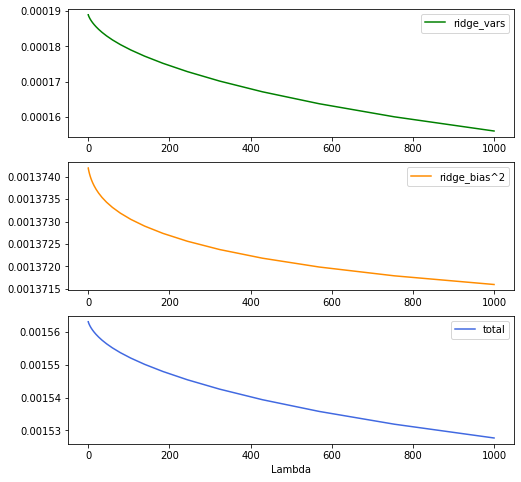

In [25]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(8, 8))
plt.subplot(311)
plt.plot(alphas, ridge_vars, label='ridge_vars', c='g')
plt.legend()
plt.subplot(312)
plt.plot(alphas, np.square(ridge_biases), label='ridge_bias^2', c='darkorange')
plt.legend()
plt.subplot(313)
plt.plot(alphas, ridge_vars + np.square(ridge_biases), label='total', c='royalblue')
plt.legend()
plt.xlabel("Lambda")
plt.show()

In the figure above, the pattern is different from the one depicted in Figure 10.5. When the intensity lambda increases, the magnitude of parameters shrinks and the model becomes simpler. Hence, the most simple seems like the best choice: adding complexity increases variance but *does not improve the bias*! One possible reason for that is that features don't actually carry much predictive value and hence a constant model is just as good as more sophisticated ones based on irrelevant variables.

### The variance-bias tradeoff: illustration

It's nonetheless useful to demonstrate how the tradeoff operates on true algorithmic choices. Below, we take the example of trees because their complexity is easy to evaluate. Basically, a tree with many terminal nodes is more complex than a tree with a handful of clusters.

We start with the parsimonious model, which we train below.

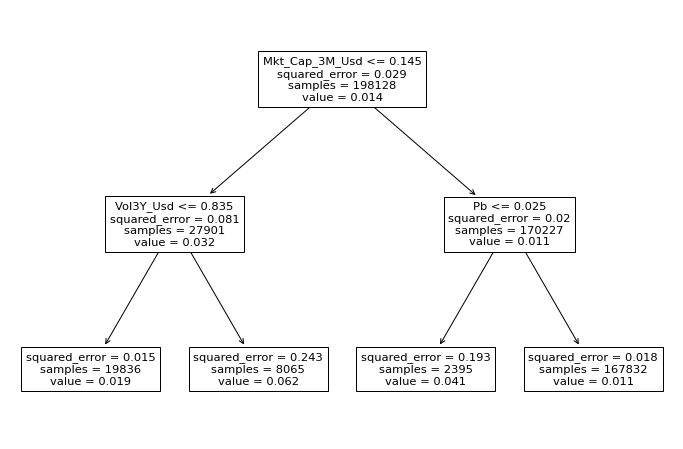

In [61]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

fit_tree_simple = DecisionTreeRegressor(ccp_alpha=0.00001, max_depth=2) # NOTE: smaller ccp_alpha than that in R coding
fit_tree_simple.fit(training_sample[features], training_sample['R1M_Usd'])
plt.figure(figsize=(12, 8))
plot_tree(fit_tree_simple, feature_names=features)
plt.show()

The model depicted in the figure above only has 4 clusters, which means that the predictions can only take 4 values. The smallest one is 0.011 and encompasses a large portion of the sample (about 85\%) and the largest one is 0.062 and corresponds to only 4% of the training sample.

We are then able to compute the bias and variance of the predictions on the *testing* set.

In [34]:
np.mean(fit_tree_simple.predict(test_sample[features]) - test_sample['R1M_Usd'])

0.004973916538330343

In [35]:
np.var(fit_tree_simple.predict(test_sample[features]))

0.00013979828544752204

On average, the error is slightly positive, with an overall overestimation of 0.005. As expected, the variance is very small $(10^{-4})$.

For the complex model, we take the boosted tree that was obtained in Section 6.4.6 (`fit_xgb`) which aggregates 40 trees with a maximum depth 4.

In [2]:
import xgboost as xgb

r1m_use_quantiles = (training_sample['R1M_Usd'].quantile(0.2), training_sample['R1M_Usd'].quantile(0.8))
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]

training_samples_xgb = training_sample[(training_sample['R1M_Usd'] < r1m_use_quantiles[0]) | (training_sample['R1M_Usd'] > r1m_use_quantiles[1])].reset_index().drop(columns = 'index')

training_features_xgb = training_samples_xgb[features_short]
training_label_xgb = training_samples_xgb['R1M_Usd']
train_matrix_xgb = xgb.DMatrix(data = training_features_xgb, label = training_label_xgb)

In [57]:
mono_const = (0, 0, -1, 1, 0, -1, 0)
fit_xgb = xgb.XGBRegressor(learning_rate = 0.3,
                           max_depth = 4,
                           subsample = 0.6,
                           colsample_bytree = 0.7,
                           reg_lambda = 1,
                           gamma = 0.1,
                           n_estimators = 40,
                           monotone_constraints = mono_const,
                           booster = 'gbtree')
fit_xgb.fit(X = training_features_xgb, y = training_label_xgb)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.1, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.3, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints=(0, 0, -1, 1, 0, -1, 0), n_estimators=40,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [58]:
xgb_test = test_sample[features_short]
np.mean(fit_xgb.predict(xgb_test) - test_sample['R1M_Usd'])

0.002358097505734665

In [59]:
np.var(fit_xgb.predict(xgb_test))

0.0033260083

The bias is indeed smaller compared to that of the simple model, but in exchange, the variance increases substantially. The net effect (via the *squared bias*) is in favor of the simpler model.

### The Risk of Overfitting: Principle

The notion of **overfitting** is one of the most important in machine learning. When a model overfits, the accuracy of its predictions will be disappointibng, thus it is one major reason why *some* strategies fail out-of-sample. Overall, we should understand *how to mitigate its effects*.

Recent reference: Hsu et al. (2018) for portfolio strategies, which builds on the work of White (2000). Both of these references do not deal with ML models, but the principle is the same - whether patterns detected are spurious.

In the following figure 10.8, we illustrate this idea with a simple visual example. A model maps $x$ into $y$ trains on data with small black circles:
- The simplest model is a constant (with only 1 parameter)
- With 2 parameters the fit is already quite good (the blue line). 
- With a sufficient number of parameters, it's possible to build a model that flows through all the points (one example with the red line). 

Now there seems to be a strange point in the dataset and the complex model fits closely to match this point.

![FIGURE 10.8: Illustration of overfitting: a model closely matching training data is rarely a good idea.](images/figure10-8.png)

A new point is added in light green which fairly follows the general pattern of the other points. The simple model is not perfect and the error is non-negligible. Nevertheless, the error stemming from the complex model (dotted gray line) is approximately twice as large - which catch *idiosyncracies* that will not occur in other datasets. These idiosyncracies should be overlooked.

### The Risk of Overfitting: Some Solutions

Obviously, the easiest way to avoid overfitting is to "avoid" complicated models.

The complexity of models is often proxied via two measures:
- The number of parameters
- Their magnitude (often synthesized through their norm)

These proxies are not perfect because some *complex* models may only require a small number of parameters (or even small parameter values), but at least they are straightforward and easy to handle. Thus, there is no universal way to handle overfitting. Below, we detail a few tricks for some families of ML tools.

For **regressions**, there are two simple ways to deal with overfitting.
- *Select a subsample of features* to reduce the number of parameters (predictors), especially highly-correlated ones (with correlation >70\%).
- *Penalization* (via LASSO, ridge or elasticnet) to reduce the magnitude of estimates and thus the variance of predictions.

For **tree-based methods**, when dealing with **simple trees**, the only way is to limit the number of leaves by:
- *Imposing a maximum depth* $d$ so that the tree can have at most $2^d$ terminal nodes. Usually we impose $d\leq 6$.
- *Shrink the size of trees* with `ccp_alpha`
- Imposes that any new split must lead to a reduction in loss greater than some `cp`
- Minimum number of instances required in each leaf
- Minimum number of instances per cluster to continue the splitting process

For **random forests**, theoretically (Breiman, 2001), control *the number of trees* only help reduce the total error via diversification rather than avoid overfitting. In practice, and for the sake of computation times, it's not recommended to go beyond 1000 trees. Other choices are the subsample size and the number of features retained for learning.

**Boosted trees** have other options that can help alleviate the risk of overfitting. The most obvious one is the *learning rate* which discounts the impact of each new tree by $\eta \in (0,1)$. When the learning rate is high, the algorithm learns too quickly and is prone to sticking close to the training data, while with low learning rate the model learns very progressively which can be efficient if there are sufficiently many trees in the ensemble. Indeed, the learning rate and the number of trees must be chosen synchronously (not both low or both large). Besides, *the penalizations, both of score values and of the number of leaves*, are naturally a tool of preventing overfitting.

Finally, constraints of monotonicity like those mentioned in Section 6.4.5 are also an efficient way to impose some structure on the model and force it to detect particular patterns.

Lastly, **neural networks** also have many options aimed at protecting from overfitting.
- Learning rate
- Penalization of weights and biases
- Constraints, e.g., non-negativity
- Dropout

## The Search for Good Hyperparameters

### Methods

Let us assume that there are $p$ parameters defined. The simplest way to proceed is to test different values and choose the one that yields the best results - *independently or sequentially*.

Independent tests are easy and come in two families: 
- *Grid (deterministic) Search*: no corners are omitted but computationally expensive. For example, each parameter is tested for 5 values which gives $5^p$ combinations. When $p$ is large (say, over 5), this may become prohibitive.
- *Random Exploration*: specifies the number of tests upfront and the parameters are drawn randomly. This can omit some optimal parameters, but Bergstra and Bengio (2012) showed that random exploration is preferable to grid search.

Note that both of them can be *suboptimal* because they are likely to spend time in zones where the parameter space is irrelevant, thereby wasting computation time. It's preferable to focus the search in areas *where the best points are most likely*. This is possible via an interative process that adapts the search after eaqc new point has been tested.

One other popular approach in this direction is **Bayesian optimization** (BO). The central object is the objective function of the learning process. We call this function $O$ which can be widely seen as a loss function possibly combined with penalization and constraints. For simplicity here, we will consider training/testing samples as fixed. The variable of interest is the vector $\boldsymbol{p}=(p_1,\dots,p_l)$ which synthesizes the hyperparameters that have an impact on $O$. The program we are interested in is $$\boldsymbol{p}_*=\arg\min_{\boldsymbol{p}}O(\boldsymbol{p})$$
The main problem with this optimization is that the computation of $O(\boldsymbol{p})$ is very costly. Therefore, it's critical to choose each trial for $\boldsymbol{b}$ wisely. One key assumption of BO is that the distribution of $O$ is *Gaussian* and that $O$ *can be proxied by a linear combination* of $p_l$ - the aim is to build a Bayesian linear regression between the input $\boldsymbol{p}$ and the output $O$. Once a model has been estimated, the information that is concentrated in the posterior density of $O$ is used to make an educated guess at where to look for new values of $\boldsymbol{p}$.

This educated guess is made based on a so-called **acquisition function**. Suppose we have tested $m$ values for $\boldsymbol{p}$, which we write $\boldsymbol{p}^{(m)}$. The current best parameter is $\boldsymbol{p}_m^*=\arg\min_{1\leq k\leq m} O(\boldsymbol{p}^{(k)})$. If we test a new point $\boldsymbol{p}$, then it will lead to an improvement only if $O(\boldsymbol{p}) < O(\boldsymbol{p}^{*}_{m})$, that is the new objective improves the minimum value that we already know. The average value of this improvement is $$\textbf{EI}_m(\boldsymbol{p})=\mathbb{E}_m[[O(\boldsymbol{p}_m^*)-O(\boldsymbol{p})]_+]$$
where the positive part $[\cdot]_+$ emphasizes that when $O(\boldsymbol{p}) \geq O(\boldsymbol{p}^{*}_{m})$ the gain is zero. The best choice for the next sample $\boldsymbol{p}^{m+1}$ is then $$\boldsymbol{p}^{m+1}=\arg\max_{\boldsymbol{p}}\textbf{EI}_m(\boldsymbol{p})$$
which corresponds to the maximum location of the expected improvement. Instead of the EI, the optimization can be performed on other measures, like the probability of improvement, which is $\mathbb{P}_m[O(\boldsymbol{p})<O(\boldsymbol{p}_m^*)]$.

In compact form, the process can be outlines as follows:
- **Step 1:** Compute $O(\boldsymbol{p}^{(m)})$ for $m=1,\dots,M_0$ values of parameters.
- **Step 2a:** Compute sequentially the posterior density of $O$ on all available points.
- **Step 2b:** Compute the optimal new point to test $\boldsymbol{p}^{m+1}$ given in $\boldsymbol{p}^{m+1}=\arg\max_{\boldsymbol{p}}\textbf{EI}_m(\boldsymbol{p})$.
- **Step 2c:** Compute the new objective value $O(\boldsymbol{p}^{m+1})$.
- **Step 3:** Repeat steps 2a to 2c as much asa deemed reasonable and return the $\boldsymbol{p}^m$ that yields the smallest objective value.

Interested readers can refer to Snock et al. (2012) and Frazier (2018) for more details on the numerical facets of this method.

Finally, for the sake of completeness, we mention a last way to tune hyperparameters. Since the optimization scheme is $\arg\min_{\boldsymbol{p}} O(\boldsymbol{p})$, a nutral way wuold be to use the sensitivity of $O$ w.r.t. $\boldsymbol{p}$. Indeed, if the gradient $\frac{\partial O}{\partial p_l}$ is known, then a *gradient descent* will always improve the objective value. The problem is that it is hard to compute a reliable gradient (finite differences can become costly). We refer to Maclaurin et al. (2015) to ways that successfully optimize over large dimensional parameter spaces.

We conclude by mentioning the survey Bouthillier and Varoquaux (2020), which spans 2 major AI conferences that took place in 2019. It shows that most papers resort to hyperparameter tuning. The two most often cited methods are *manual turning* (hand-picking) and *grid search*.

### Example: Grid Search

In order to illustrate the process of grid search, we will try to find the best parameters for a boosted tree. We seek to quantify the impact of three parameters:
- **ETA** $\eta$, the learning rate;
- **N_ROUNDS** or **`N_estimators`**, the number of trees that are grown;
- **Lambda** or $\lambda$, the weight regularizer which penalizes the objective function through the total sum of squared weights/scores.

Below, we create a grid with the values we want to test for these parameters.

In [14]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

param_grids = {
    "learning_rate": [0.1, 0.3, 0.5, 0.7, 0.9],
    "n_estimators": [10, 50, 100],
    "reg_lambda": [0.01, 0.1, 1, 10, 100]
}

xgb_tmp_model = XGBRegressor(max_depth=5, objective="reg:squarederror", gamma=0.1)
xgb_grid_search = GridSearchCV(xgb_tmp_model, param_grid=param_grids, 
                               scoring='neg_mean_squared_error',
                               verbose=1)
xgb_grid_search.fit(training_features_xgb, training_label_xgb)
print(f'Best Parameters using grid search: {xgb_grid_search.best_params_}')

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best Parameters using grid search: {'learning_rate': 0.1, 'n_estimators': 50, 'reg_lambda': 100}


Once the squared mean errors have been gathered, it is possible to plot them. We chose to work with 3 parameters on purpose because their influence can be simultaneuously plotted on one graph.

In [16]:
def facet_visualization(cv_results):
    res_df = pd.DataFrame(cv_results, 
                          columns = ["param_n_estimators","param_learning_rate","param_reg_lambda","mean_test_score"])
    color_list = ['darkorange', 'olive', 'seagreen', 'cornflowerblue', 'crimson']
    # Note, MAE is made negative in the scikit-learn library so that it can be maximized. 
    # As such, we can ignore the sign and assume all errors are positive.
    res_df['mean_test_score'] = -res_df['mean_test_score'].values

    fig, axes = plt.subplots(figsize=(20, 12), nrows=3, ncols=5)
    ax_all = plt.gca()

    cnt = 0
    for param, tmp in res_df.groupby(["param_n_estimators", "param_reg_lambda"]):
        ax = axes[cnt//5][cnt%5] # get the ax
        np.round(tmp[["param_learning_rate","mean_test_score"]], 2).plot.bar(ax=ax, x="param_learning_rate", y="mean_test_score", alpha=0.5,legend=None, color=color_list)
        ax.set_xlabel("") # no xlabel
        ax.set_ylim(0, 0.1) # set y range
        # adjust xtick labels / adjust ytick labels
        if cnt // 5 < 2:
            ax.xaxis.set_ticklabels("")
        else:
            for label in ax.get_xticklabels():
                label.set_rotation(0);
        if cnt % 5 > 0:
            ax.yaxis.set_ticklabels("")
        # set title
        ax.set_title(f"num_trees={param[0]},\n reg_lambda={param[1]}",fontsize=10)
        cnt += 1
    # fig.subplots_adjust(wspace=0.1, hspace=0.25)
    fig.supxlabel('Eta', x=0.5, y=0.05, fontsize=30)
    fig.supylabel('Error', x=0.08, y=0.5, fontsize=30)
    plt.show()

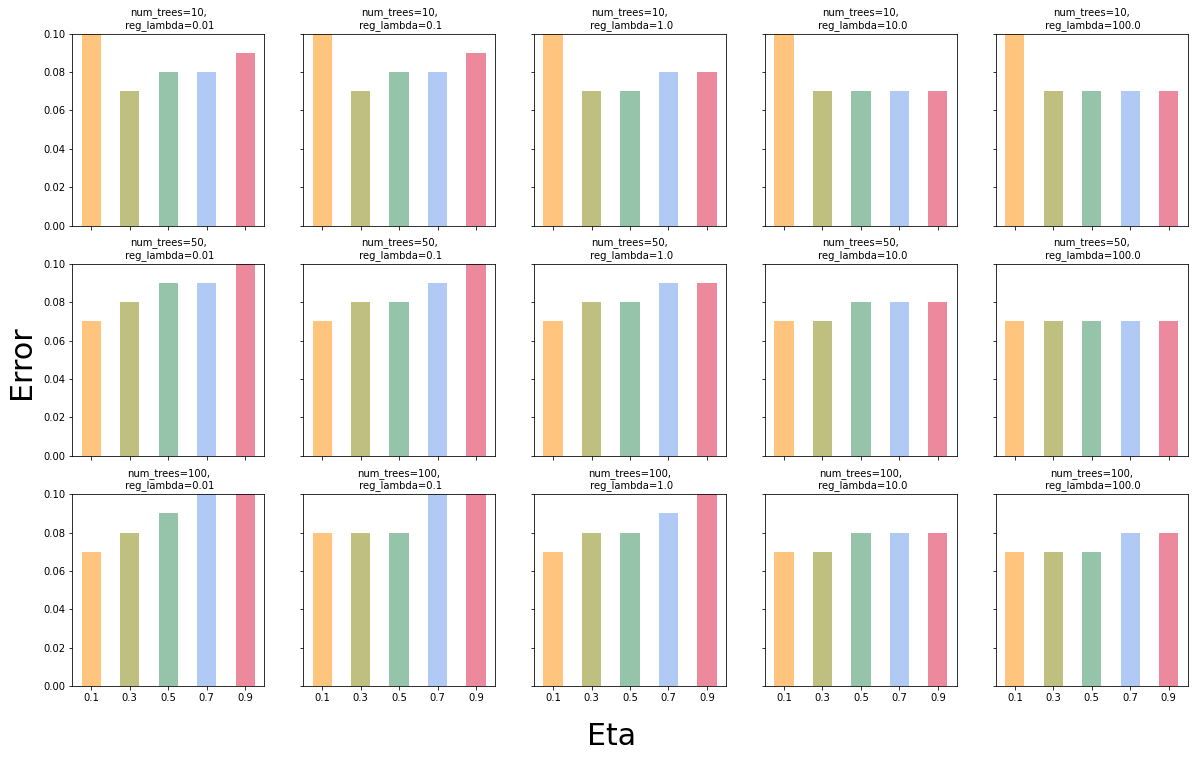

In [15]:
cv_results = xgb_grid_search.cv_results_
facet_visualization(cv_results)

In Figure 10.9, the main information is that a small learning rate $(\eta=0.1)$ is detrimental to the quality when the number of trees is small (`n_estimators`$=10$), which means that the algorithm does not learn enough.

Grid search can be performed in two stages: 
- The first helps locates the zones of interest
- The second zoom in on those zones with refined values for the parameter

With the results above, you would consider in this case:
- many learners (more than 50, possibly more than 100)
- avoid large learning rates such as $\eta=0.9$ or $\eta=0.8$.

### Example: Bayesian Optimization

There are several Python packages relate to Bayesian optimization, such as `PyMC`, `skopt` or `HyperOpt`, etc. We work with `Scikit-Optimize` or `skopt` as an example.

Just as for the grid search, we need to code the objective function on which the hyperparameters will be optimized.

In [7]:
from skopt import BayesSearchCV
xgb_bayes_search = BayesSearchCV(xgb_tmp_model, search_spaces=param_grids, 
                                 scoring='neg_mean_squared_error')
xgb_bayes_search.fit(training_features_xgb, training_label_xgb)

c:\Users\SamuelZhang\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.1, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bi...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
              scoring='neg_mean_squared_error',
              search_spaces={'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9],
                             'n_estimators': [10, 50, 100],
                             'reg_lambda': [0.01, 0.1, 1, 10, 100]})

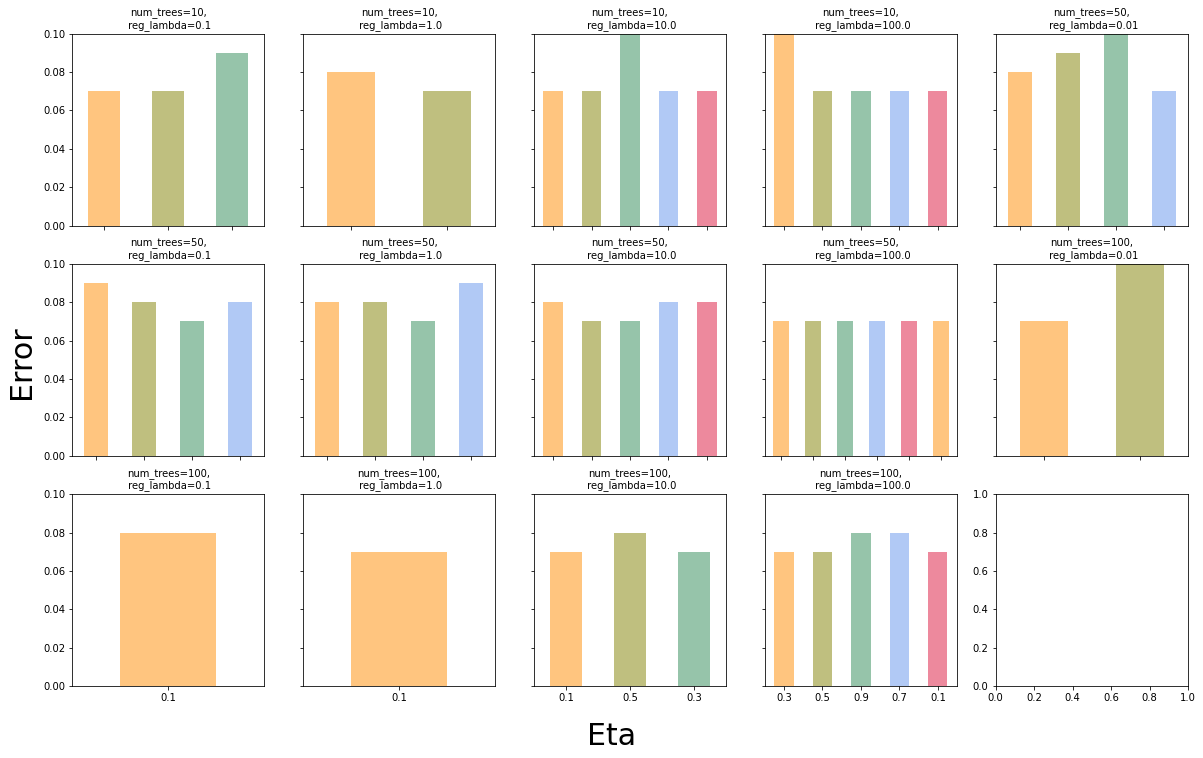

In [13]:
cv_results_bayes = xgb_bayes_search.cv_results_
facet_visualization(cv_results_bayes)

In [17]:
xgb_bayes_search.best_params_

OrderedDict([('learning_rate', 0.1),
             ('n_estimators', 50),
             ('reg_lambda', 100.0)])

## Short Discussion on Validation in Backtests

The topic of validation in backtests is more complex than it seems.

(Option 1 as follows)

Let us start with building a unique model and to test it on different time periods. There is ongoing debate on how to validate a model in that case. Usually, it makes sense to test the model on successive dates, moving forward posterior to the training, which would replicate what would happen in a live situation.

In machine learning, a popular approach is to split the data into $K$ partitions and to test $K$ different models on one partition but trained on the $K-1$ others. This so-called **cross-validation (CV)** is proscribed by most experts for simply, most of time, the training set encompasses data from future dates and tests on past values. Nonetheless, some advocate one particular form of CV aiming at making sure that there is no informational overlap between the training and testing set - if the structure of the cross-section of returns is constant over time, then training on future while testing on past data is not problematic as long as there is no overlap. You may refer to Schnaubelt (2019) for a comprehensive tour in validation schemes.

One example cited in De Prado (2018) is the reaction to a model to an unseen crisis - no major financial shake since 2008, so one option is to test a model trained with recent years (say 2015-2019) and test in on various months in 2008 to see how it performs.

The advantage of a fixed model is that validation is easy and can be easily repeated for different sets of parameters.

(Option 2 as follows)

The second major option is when the model is updated (retrained) at each rebalancing - the structure of returns may evolve through time and a dynamic model will capture the most recent trends. The drawback is that validation should be rerun at each rebalancing date.

Let us recall the dimensions of backtests:
- Number of **strategies**: possibly dozens or hundreds, or even more
- Number of trading **dates**: hundreds for monthly rebalancing
- Number of **assets**: hundreds of thousands
- Number of **features**: dozens or hundreds

Even with a lot of computational power, training many models over many dates is time-consuming, especially when it comes to hyperparameter tuning when the parameter space is large. Thus, validating models at each trading date of the out-of-sample period is not realistic.

One solution is to keep an early portion of the training data and to perform a smaller scale validation on this subsample. Hyperparameters are tested on a limited number of dates and most of the time, they exhibit stability: satisfactory parameters for one date are usually acceptable for the next one and following ones as well. Thus, the full backtest can be carried out with these values when updating the models at each period. The backtest nonetheless remains compute-intensive because the model has to be retrained with the most recent data for each rebalancing date.

## Takeaways

- Learning Metrics
  - Aim: measuring model performance (with different sets of *hyperparameters*)
  - Regression Analysis
    - MAE, MSE(RMSE), $R^2$, MAPE, MASE, RMSLE
    - MSE may not be optimal for factor investing because the cross-sectional term is most important and always to the investor's benefit
  - Classification Analysis
    - TP, TN, FP, FN, confusion matrix
    - Accuracy, Recall, Precision, Specificity, Fallout, F-score
    - ROC curve: specificity and sensitivity under different thresholds
    - AUC: Area Under (ROC) Curve, usually greater than 0.5
- Validation
  - Variance-bias tradeoff
    - Decompose $\mathbb{E}[\hat{\epsilon}^2]$ into variance and squared bias part
    - Model complexity: trade-off with error (e.g. ridge regression)
  - Overfitting
    - Spurious patterns (or "idiosyncracies") in the training data
    - Solutions: less complicated models
      - Regression: number of predictors, penalization
      - Simple Trees: number of leaves, max depth, minimum loss reduction, minimum instances per leaf, minimum instances per cluster for future splitting, etc.
      - Random Forests: number of trees, subsample size, number of features
      - Boosted Trees: learning rate, penalizations (on score values and number of leaves)
      - Neural Networks: learning rate, penalization, constraints, dropout
- The Search for Good Hyperparameters
  - Grid Search: Exhaustive but computationally expensive
  - Random Search: More efficient but can omit optimal parameters
  - Bayesian Optimization: Gaussian distribution assumption, acquisition function, expected improvement
- Validation in Backtests
  - Option 1: model fixed and cross-validation
    - Debate on whether training with future data while testing with historical data is fine
    - May be useful to test the model against crisis
    - Easier validation
  - Option 2: model updated at each rebalancing
    - Validation is time-consuming
    - A smaller scale validation on a subsample of training data